### Exercise 2b)

In [2]:
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
from utils.training import GradientDescent, StochasticGradientDescent
from utils.step_methods import ConstantLearningRateStep, MomentumStep, ADAgradStep, RMSpropStep, AdamStep

In [3]:
from utils.cost_functions import SoftmaxCrossEntropy,MSE
from utils.activation_functions import Sigmoid, Identity
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from utils.utils import generate_dataset

In [4]:
np.random.seed(124)

x,y = generate_dataset()

In [5]:
def runge(x): 
    return 1/(1 + 25*x**2)

x = x.reshape(-1,1)
y = y.reshape(-1,1)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 44)

n_folds = 5

kfold = KFold(n_splits=n_folds,shuffle=True,random_state=44)

Testing MSE for OLS linear regression:  0.0033842036002902426


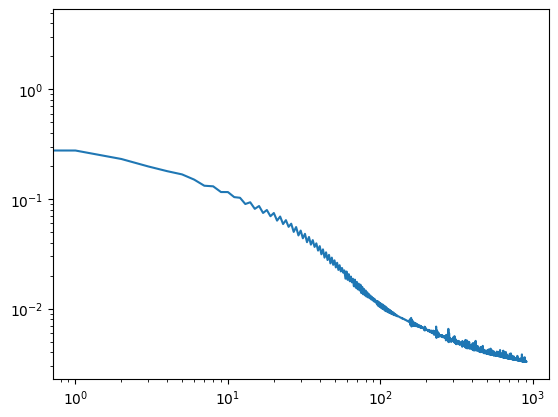

Testing MSE for neural network before training:  13.171450200389852
Testing MSE for neural network after training:  0.0035822172760644547


In [6]:
model = LinearRegression(fit_intercept=True)

model = make_pipeline(PolynomialFeatures(degree=12, include_bias=True), StandardScaler(), model)

estimated_mse_folds = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=kfold)
mse_OLS = np.mean(-estimated_mse_folds)

print("Testing MSE for OLS linear regression: ",mse_OLS)

network_input_size = 1
network_output_size = 1

layer_output_sizes = [50, 50, network_output_size]
activation_funcs = [Sigmoid(), Sigmoid(), Identity()]

no_train_mse = np.zeros(n_folds)
train_mse = np.zeros(n_folds)

for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
    net = NeuralNetwork(network_input_size,
        layer_output_sizes,
        activation_funcs,
        MSE(),
    )
    x_train = x[train_idx]
    x_test = x[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    no_train_mse[fold_idx] = net.cost_batch(x_test,y_test)
    net.train(StochasticGradientDescent(step_method=RMSpropStep(learning_rate=0.01, decay_rate=0.9),inputs = x_train, targets = y_train))
    train_mse[fold_idx] = net.cost_batch(x_test,y_test)

net.plot_loss()

print("Testing MSE for neural network before training: ",np.mean(no_train_mse))

print("Testing MSE for neural network after training: ",np.mean(train_mse))


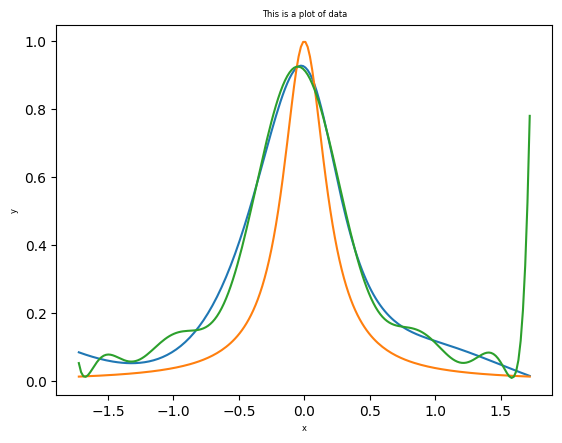

In [10]:
x_test = scaler.fit_transform(np.linspace(-1,1, 200).reshape(-1,1))
y_pred = net.predict(x_test)

#model = LinearRegression(fit_intercept=False)

#model = make_pipeline(PolynomialFeatures(degree=12, include_bias=False), StandardScaler(), model)

plt.plot(x_test,y_pred)   #,label="Neural network"
plt.plot(x_test,runge(x_test))   #,label="Runge function"
plt.plot(x_test,model.fit(x_train.reshape(-1,1), y_train).predict(x_test))
plt.xlabel("x",fontsize=6)
plt.title("This is a plot of data",fontsize = 6)
plt.ylabel("y",fontsize=6)
plt.show()

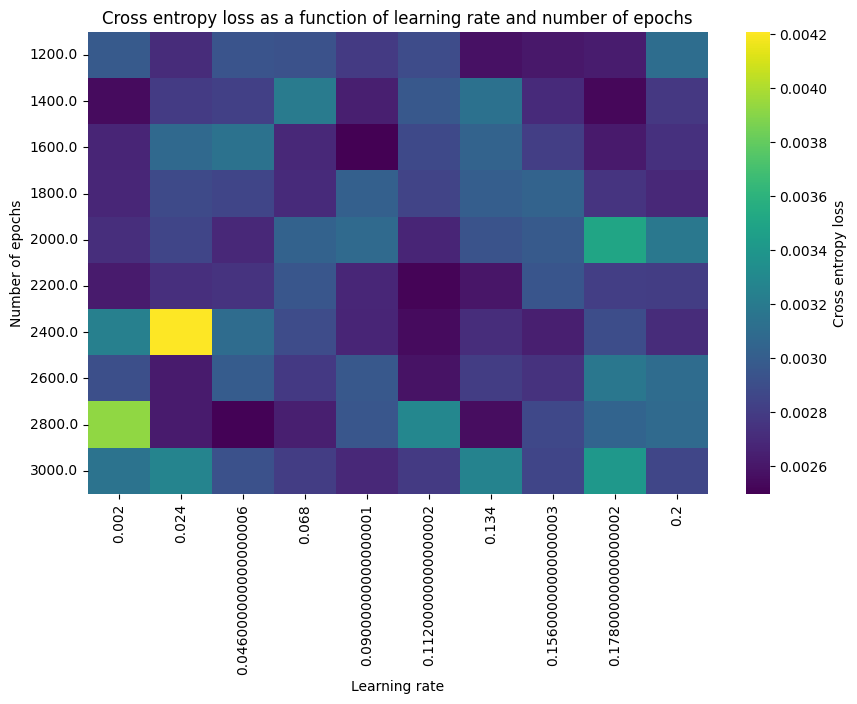

In [ ]:
import seaborn as sns

learning_rates = np.linspace(0.002,0.2,10)
epochs = np.linspace(1200,3000,10)

loss = np.zeros((len(epochs),len(learning_rates)))

for i in range(len(learning_rates)):
    for j in range(len(epochs)):
        for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
            net = NeuralNetwork(network_input_size,
                layer_output_sizes,
                activation_funcs,
                MSE(),
            )
            x_train = x[train_idx]
            x_test = x[test_idx]
            y_train = y[train_idx]
            y_test = y[test_idx]
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
            net.train(StochasticGradientDescent(step_method=RMSpropStep(learning_rate=0.01, decay_rate=0.9),inputs = x_train, targets = y_train),2000)
            loss[j,i] = net.cost_batch(x_test,y_test)

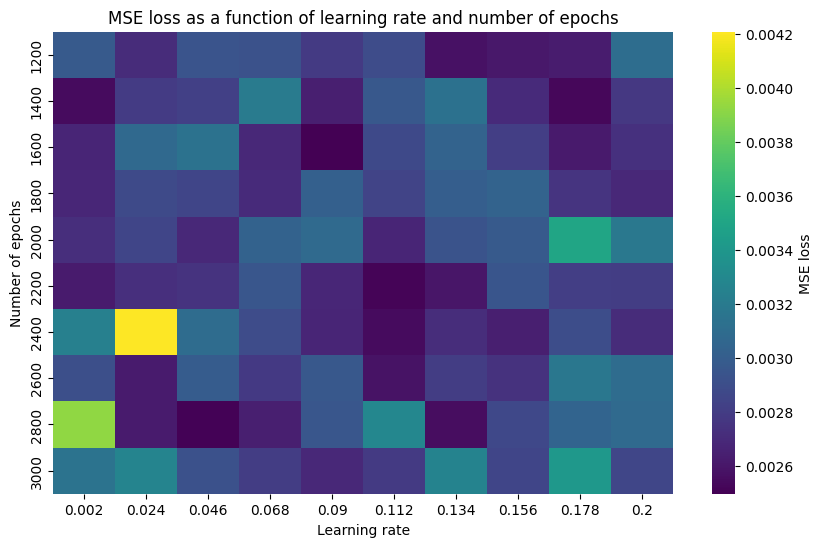

In [ ]:
# display a heatmap, where the color represnts the value of the accuracy
plt.figure(figsize=(10, 6))
sns.heatmap(
    loss,  
    fmt=".2f",   
    cmap="viridis", 
    xticklabels=np.round(learning_rates,3),
    yticklabels=epochs.astype("int"),cbar_kws={"label": "MSE loss"}
)

plt.xlabel("Learning rate")
plt.ylabel("Number of epochs")
plt.title("MSE loss as a function of learning rate and number of epochs")
plt.show()

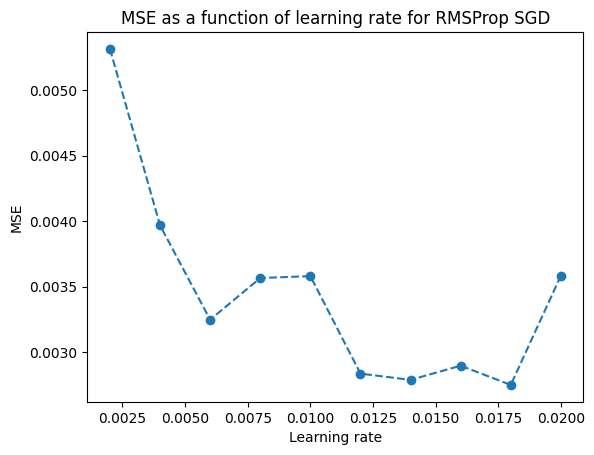

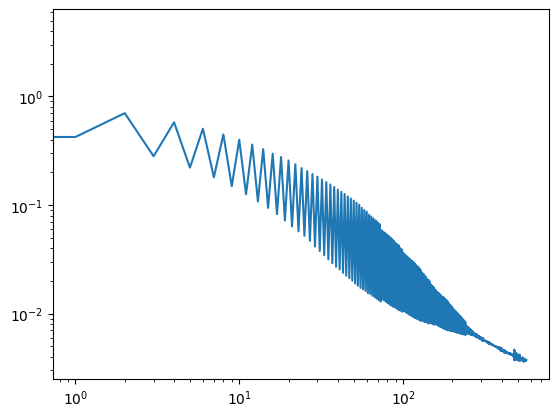

In [7]:
# Stochastic gradient descent, with RMSProp

learning_rates = np.linspace(0.002,0.02,10)

loss = np.zeros(len(learning_rates))

for i in range(len(learning_rates)):
        for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
            net = NeuralNetwork(network_input_size,
                layer_output_sizes,
                activation_funcs,
                MSE(),
            )
            x_train = x[train_idx]
            x_test = x[test_idx]
            y_train = y[train_idx]
            y_test = y[test_idx]
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
            net.train(StochasticGradientDescent(step_method=RMSpropStep(learning_rate=learning_rates[i], decay_rate=0.9),inputs = x_train, targets = y_train))
            loss[i] = net.cost_batch(x_test,y_test)

plt.plot(learning_rates,loss,"o",linestyle="--")
plt.xlabel("Learning rate")
plt.ylabel("MSE")
plt.title("MSE as a function of learning rate for RMSProp SGD")

plt.show()
net.plot_loss()

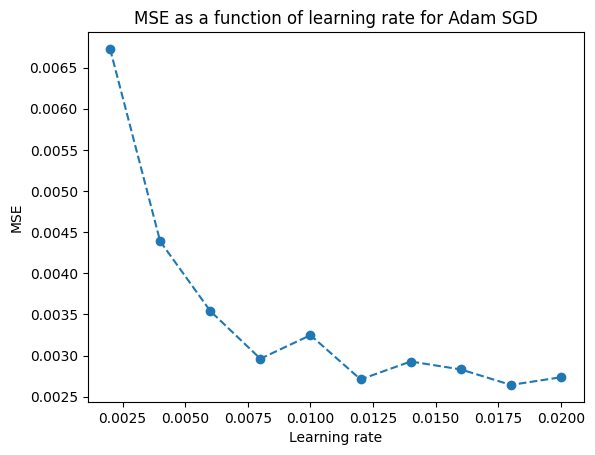

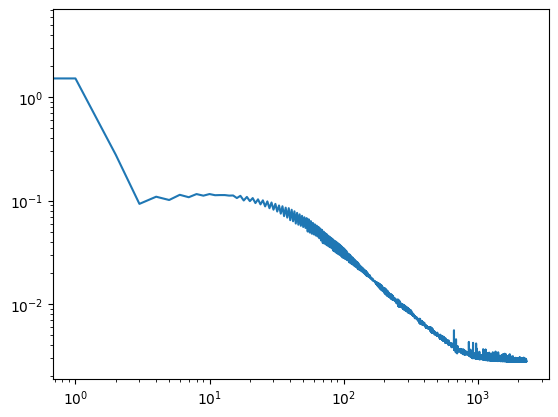

In [8]:
learning_rates = np.linspace(0.002,0.02,10)

loss = np.zeros(len(learning_rates))

for i in range(len(learning_rates)):
        for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
            net = NeuralNetwork(network_input_size,
                layer_output_sizes,
                activation_funcs,
                MSE(),
            )
            x_train = x[train_idx]
            x_test = x[test_idx]
            y_train = y[train_idx]
            y_test = y[test_idx]
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
            net.train(StochasticGradientDescent(step_method=AdamStep(learning_rate=learning_rates[i]),inputs = x_train, targets = y_train))
            loss[i] = net.cost_batch(x_test,y_test)

plt.plot(learning_rates,loss,"o",linestyle="--")
plt.xlabel("Learning rate")
plt.ylabel("MSE")
plt.title("MSE as a function of learning rate for Adam SGD")
plt.show()

net.plot_loss()

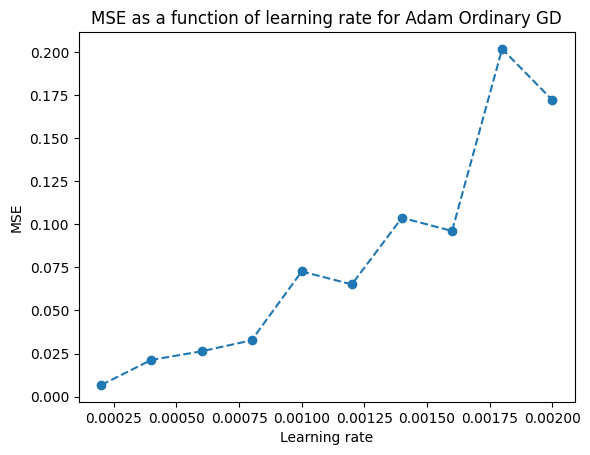

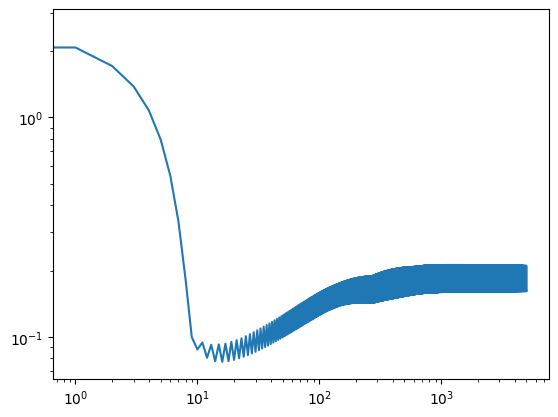

: 

In [ ]:
learning_rates = np.linspace(0.00002,0.0002,10)

loss = np.zeros(len(learning_rates))

for i in range(len(learning_rates)):
        for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
            net = NeuralNetwork(network_input_size,
                layer_output_sizes,
                activation_funcs,
                MSE(),
            )
            x_train = x[train_idx]
            x_test = x[test_idx]
            y_train = y[train_idx]
            y_test = y[test_idx]
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
            net.train(GradientDescent(step_method=AdamStep(learning_rate=learning_rates[i]),inputs = x_train, targets = y_train))
            loss[i] = net.cost_batch(x_test,y_test)

plt.plot(learning_rates,loss,"o",linestyle="--")
plt.xlabel("Learning rate")
plt.ylabel("MSE")
plt.title("MSE as a function of learning rate for Adam Ordinary GD")
plt.show()

net.plot_loss()

In [ ]:
learning_rates = np.linspace(0.00002,0.0002,10)

loss = np.zeros(len(learning_rates))

for i in range(len(learning_rates)):
        for fold_idx,(train_idx, test_idx) in enumerate(kfold.split(x)): 
            net = NeuralNetwork(network_input_size,
                layer_output_sizes,
                activation_funcs,
                MSE(),
            )
            x_train = x[train_idx]
            x_test = x[test_idx]
            y_train = y[train_idx]
            y_test = y[test_idx]
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
            net.train(GradientDescent(step_method=RMSpropStep(learning_rate=learning_rates[i],decay_rate = 0.9),inputs = x_train, targets = y_train))
            loss[i] = net.cost_batch(x_test,y_test)

plt.plot(learning_rates,loss,"o",linestyle="--")
plt.xlabel("Learning rate")
plt.ylabel("MSE")
plt.title("MSE as a function of learning rate for RMSProp Ordinary GD")
plt.show()

net.plot_loss()